# 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn

In [3]:
# 이미지의 가로 세로
IMG_SIZE = 224
# 비디오에서 학습할 프레임 개수
MAX_SEQ_LENGTH = 20

In [4]:
# 데이터 경로
data_path = "/content/drive/MyDrive/인공지능 자연어처리 및 음성인식 음성합성 기술을 활용한 응용 SW 개발자 양성과정 /4.딥러닝_프로젝트/workspace/"

In [5]:
# 학습 데이터의 파일명과 종류가 저장된 train.csv 를 읽음
train_df = pd.read_csv(data_path + "train.csv")


In [6]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing


In [7]:
# 비디오의 종류가 저장된 tag 컬럼을 label 컬럼에 대입
train_df["label"] = train_df["tag"]

In [8]:
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot,CricketShot
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,TennisSwing
352,v_TennisSwing_g25_c03.avi,TennisSwing,TennisSwing
353,v_TennisSwing_g25_c04.avi,TennisSwing,TennisSwing
354,v_TennisSwing_g25_c05.avi,TennisSwing,TennisSwing


In [9]:
# label 컬럼에 저장된 데이터를 중복을 제거하고 조회
train_df["label"].unique()

array(['CricketShot', 'Punch', 'TennisSwing'], dtype=object)

In [10]:
# enumerate(train_df["label"].unique()) : label 컬럼에 저장된 데이터를 중복을 제거한 값에 인덱스 추가
for index, data in enumerate(train_df["label"].unique()):
    # label 컬럼에 저장된 data 를 index로 변환
    train_df["label"].replace(data, index, inplace=True) 

In [11]:
# label 컬럼에 저장된 값이 숫자로 변환 되었음
train_df

,video_name,tag,label
0,v_CricketShot_g08_c01.avi,CricketShot,0
1,v_CricketShot_g08_c02.avi,CricketShot,0
2,v_CricketShot_g08_c03.avi,CricketShot,0
3,v_CricketShot_g08_c04.avi,CricketShot,0
4,v_CricketShot_g08_c05.avi,CricketShot,0
...,...,...,...
351,v_TennisSwing_g25_c02.avi,TennisSwing,2
352,v_TennisSwing_g25_c03.avi,TennisSwing,2
353,v_TennisSwing_g25_c04.avi,TennisSwing,2
354,v_TennisSwing_g25_c05.avi,TennisSwing,2


In [12]:
# sklearn.utils.shuffle(train_df) : train_df에 저장된 행을 섞음
train_df = sklearn.utils.shuffle(train_df)

In [13]:
# train_df에 저장된 줄이 섞였음
train_df

,video_name,tag,label
267,v_TennisSwing_g12_c02.avi,TennisSwing,2
346,v_TennisSwing_g24_c03.avi,TennisSwing,2
68,v_CricketShot_g17_c06.avi,CricketShot,0
20,v_CricketShot_g10_c07.avi,CricketShot,0
53,v_CricketShot_g15_c05.avi,CricketShot,0
...,...,...,...
225,v_Punch_g24_c01.avi,Punch,1
158,v_Punch_g13_c07.avi,Punch,1
355,v_TennisSwing_g25_c06.avi,TennisSwing,2
250,v_TennisSwing_g09_c06.avi,TennisSwing,2


In [14]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
# frame : 비디오를 구성하는 이미지
def crop_center_square(frame):
    # frame.shape[0:2] : 이미지의 세로, 가로 리턴
    y, x = frame.shape[0:2]
    # 이미지의 세로 가로 중에서 작은 값을 리턴
    min_dim = min(y, x)
    #이미지의 왼쪽 모서리 좌표의 가로 시작점
    # 이미지 가로 좌표 (이미지 가로 //2  - min_dim//2) ~ (이미지 가로 //2  + min_dim//2) 
    start_x = (x // 2) - (min_dim // 2)
    # 이미지의 왼쪽 모서리 세로 좌표 시작점
    # 이미지 세로 좌표 (이미지 세로 //2  - min_dim//2) ~ (이미지 세로 //2  + min_dim//2) 
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [15]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
# path : 비디오 파일 경로
# max_frames : 이미지로 변환할 프레임수
# resize=(IMG_SIZE, IMG_SIZE) : 이미지의 가로 세로
def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    # 비디오 파일을 읽어서 이미지로 변환 할 객페
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # cap.read() : 비디오를 읽어서 리턴
            # ret : 비디오 읽기가 성공했으면 True, 더이상 읽을 비디오 프레임이 없으면 False 가 리턴
            # frame : 비디오 프레임 이미지를 리턴
            ret, frame = cap.read()
            # ret 가 False면 반복 종료
            if not ret:
                break
            # 비디오 이미지를 가운데 리턴
            frame = crop_center_square(frame)
            #비디오 이미지의 가로 세로를 resize=(224,224) 로 변환
            frame = cv2.resize(frame, resize)
            # frame 은  [줄, 칸, B G R ] 로 구성되 있음 
            # frame [ : (모든줄), : (모든칸), R (인덱스2) G (인덱스1) B (인덱스0 )] 리턴
            frame = frame[:, :, [2, 1, 0]]
            # frame을 frames에 추가
            frames.append(frame)
            # frames에 저장된 데이터수가 max_frames와 같으면 종료
            if len(frames) == max_frames:
                break
    finally:
        # 비디오 이미지 변환 종료
        cap.release()
    # frames를 numpy 배열로 변환 해서 리턴
    return np.array(frames)


In [16]:
# video 파일명 리턴
train_df["video_name"].loc[0]

'v_CricketShot_g08_c01.avi'

In [17]:
# 비디오 파일의 프레임을 이미지로 변환해서 리턴
video = load_video(data_path+"train/"+train_df["video_name"].loc[0])

In [18]:
# 비디오 파일 프레임 이미지 조회
video

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0,

In [19]:
video.shape

(20, 224, 224, 3)

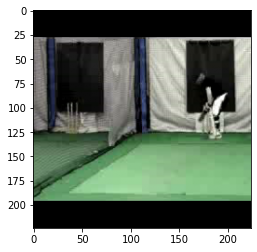

In [20]:
# 첫번째 프레임 출력
plt.imshow(video[0]/255)

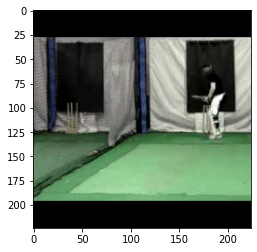

In [21]:
# 10번째 프레임 출력
plt.imshow(video[10]/255)

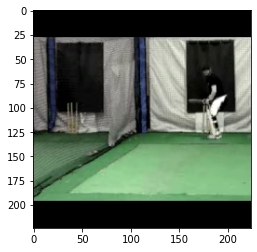

In [22]:
# 19번째 프레임 조회
plt.imshow(video[19]/255)

In [23]:
# 비디오 파일 종류 조회
train_df["label"].values

array([2, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 2, 2, 1, 1, 1, 1, 2, 0, 1,
       2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2,
       2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 1,
       0, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 2,
       0, 2, 1, 2, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2,
       1, 2, 1, 0, 1, 2, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1,
       0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2,
       2, 2, 1, 2, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 0, 0, 2, 1, 1,
       0, 2, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 2, 2, 0, 1, 2, 0,
       1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1,
       1, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 2, 0, 1, 2,
       0, 0, 1, 2, 0, 0, 1, 2, 1, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0,
       2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 0, 1,

In [24]:
# 비디오 파일의 종류를 2차원 배열로 변환
train_df["label"].values.reshape(-1,1)

array([[2],
       [2],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [2],
       [1],
       [2],
       [0],
       [2],
       [2],
       [2],
       [1],
       [1],
       [1],
       [1],
       [2],
       [0],
       [1],
       [2],
       [1],
       [1],
       [1],
       [2],
       [0],
       [2],
       [1],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [1],
       [2],
       [0],
       [1],
       [2],
       [1],
       [2],
       [0],
       [0],
       [2],
       [1],
       [0],
       [0],
       [1],
       [2],
       [2],
       [0],
       [1],
       [2],
       [1],
       [0],
       [2],
       [2],
       [0],
       [0],
       [0],
       [2],
       [2],
       [1],
       [1],
       [2],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
    

In [25]:
# 모든 비디오 파일의 이미지와 종류를 리턴
# video_name : 비디오 파일명
# label: 비디오 파일 종류
# root_dir : 비디오 파일 경로
def prepare_all_videos(video_name , label, root_dir):
    # 비디오 파일 이름의 개수
    num_samples = len(video_name)
    # video_name.values.tolist() : 비디오 파일 이름을 리스트로 변환 해서 리턴
    video_paths = video_name.values.tolist()
    # 비디오 종류를 리턴
    labels = label.values
    # 비디오 종류를 2차원 배열로 변환
    labels = labels.reshape(-1,1)
    # 0으로 초기화된 [비디오 파일개수 * 20 , 224 , 224, 3] 배열 생성
    x = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3 ), dtype="float32" )
    # 0으로 초기화된 [비디오파일개수 * 20] 인 배열 생성
    y = np.zeros(shape=(num_samples*MAX_SEQ_LENGTH), dtype="float32")
    # 인덱스 초기화
    index = 0
    # 비디오 파일의 개수 만큼 반복
    for idx, path in enumerate(video_paths):
        # 비디오 파일을 읽어서 각 프레임의 이미지를 리턴
        frames = load_video(root_dir+ path)
        # 프레임의 개수 만큼 반복
        for i in range(len(frames)):
            # frame의 i번째 이미지를 x에 추가
            x[index] = np.array(frames[i], dtype="float32")
            # 비디오의 종류가 저장된 labels의 idx 번째를 y에 추가
            y[index]= np.array(labels[idx], dtype="float32")
            # index 1 증가
            index += 1 
    
    # 전체 비디오 프레임을 이미지로 변환한 x 
    # to_categorical(y) : 이미지의 종류 y 를 onehot 인코딩 
    return (x,to_categorical(y))

In [26]:
# 비디오 프레임을 이미지로 변환한 데이터를 X_train에 저장
# 비디오 프레임 이미지의 종류를 y_train에 저장
X_train, y_train = prepare_all_videos(train_df["video_name"], train_df["label"] , data_path + "train/")

In [27]:
# 전체 비디오 프레임을 이미지로 변환한 데이터 조회
X_train

array([[[[ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         ...,
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.]],

        [[ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         ...,
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.]],

        [[ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         ...,
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.]],

        ...,

        [[ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         ...,
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.]],

        [[ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         ...,
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.],
         [ 16.,  16.,  16.]],

        [[ 16.,  16.,  16.],
       

In [28]:
X_train.shape

(7120, 224, 224, 3)

In [29]:
#비디오 종류
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [30]:
y_train.shape

(7120, 3)

In [31]:
X_train[0].shape

(224, 224, 3)

In [32]:
#0번째 이미지 조회
X_train[0]

array([[[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       ...,

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]]

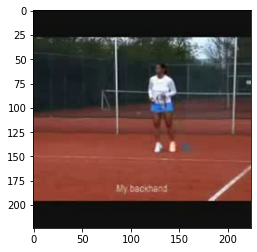

In [33]:
# 0번째  이미지
plt.imshow(X_train[0]/255)

In [34]:
# 0번째 이미지 종류
y_train[0]

array([0., 0., 1.], dtype=float32)

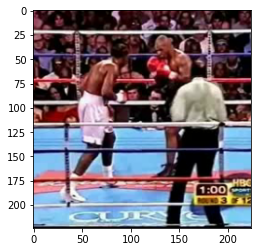

In [35]:
# 100번째  이미지
plt.imshow(X_train[100]/255)

In [36]:
# 100번째 이미지 종류
y_train[100]

array([0., 1., 0.], dtype=float32)

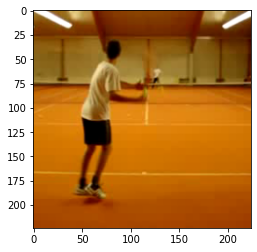

In [37]:
# 1000 번째 이미지
plt.imshow(X_train[1000]/255)

In [38]:
# 1000 번째 이미지 종류
y_train[1000]

array([0., 0., 1.], dtype=float32)

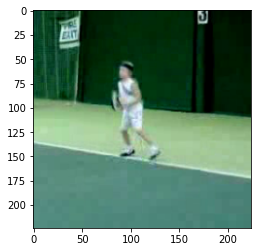

In [39]:
# 4759 번째  이미지
plt.imshow(X_train[4759]/255)

In [40]:
# 4759 번째 이미지 종류
y_train[4759]

array([0., 0., 1.], dtype=float32)

# 모델 생성

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [42]:
#입력값을 읽어서 예측을 할 Sequential 객체 생성
model = Sequential()

In [43]:
#Conv2D() :합성곱 연산을 수행

#Conv2D(필터개수, kernel_size=(필터줄, 필터칸), input_shape=(이미지줄, 이미지칸, 컬러3 흑백1 ),
#       activation='활성함수', padding="SAME")
#Conv2D(32, kernel_size=(3, 3), input_shape=(224, 224, 3),activation='relu', padding="SAME") 

#필터 개수 : 32
#필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
#입력 이미지 : input_shape=(224, 224, 3) 가로 224 세로 224 컬러
#활성 함수: activation='relu' 활성함수 relu 사용
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

model.add(Conv2D(32, kernel_size=(3, 3),  input_shape=(224, 224, 3),activation='relu', padding="SAME"))

In [44]:
#MaxPooling2D()맥스 풀링 연산을 수행 
#pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

In [45]:
#Conv2D() :합성곱 연산을 수행

#Conv2D(필터개수, kernel_size=(필터줄, 필터칸),strides=이동칸수, activation='활성함수', padding="SAME")
#Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME")

#필터 개수 : 64
#필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
#활성 함수: activation='relu' 활성함수 relu 사용
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME"))

In [46]:
#MaxPooling2D()맥스 풀링 연산을 수행 
#pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

In [47]:
#Conv2D() :합성곱 연산을 수행

#Conv2D(필터개수, kernel_size=(필터줄, 필터칸),strides=이동칸수, activation='활성함수', padding="SAME")
#Conv2D(64, kernel_size=(3, 3),activation='relu',padding="SAME")

#필터 개수 : 128
#필터의 줄 칸: kernel_size=(3, 3) 3줄 3칸
#활성 함수: activation='relu' 활성함수 relu 사용
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함

model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding="SAME"))

In [48]:
#MaxPooling2D()맥스 풀링 연산을 수행 
#pool_size=2 : 입력 데이터에서 2줄 2칸을 하나의 그룹으로 최대값을 리턴
#padding="SAME" : 입력 이미지 오른쪽 끝 아래 끝에 0을 삽입해서 입력 데이터와 출력 데이터의 줄 칸의 개수가 같도록 함
model.add(MaxPooling2D(pool_size=2,  padding="SAME"))

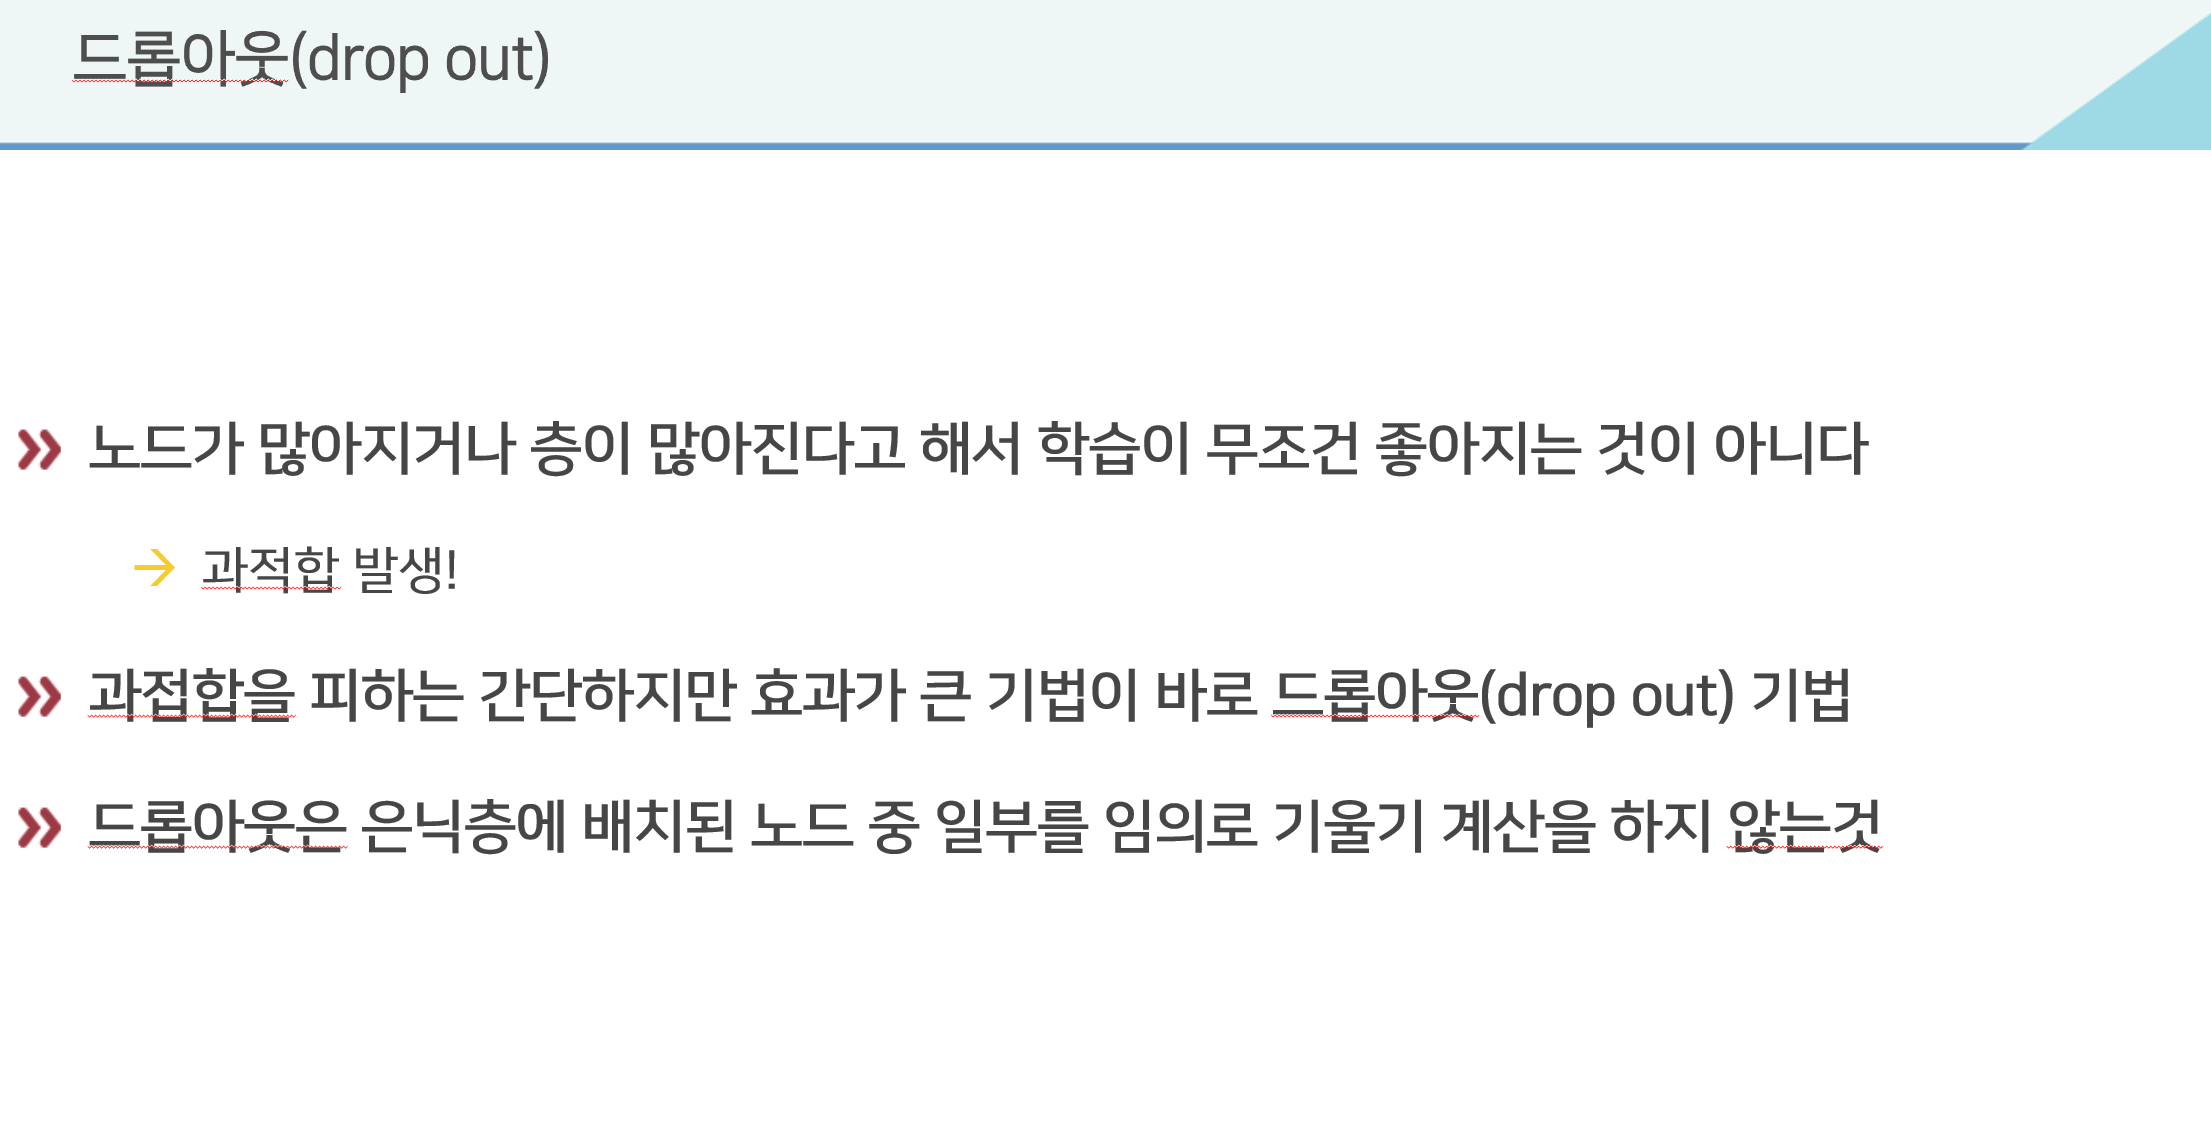

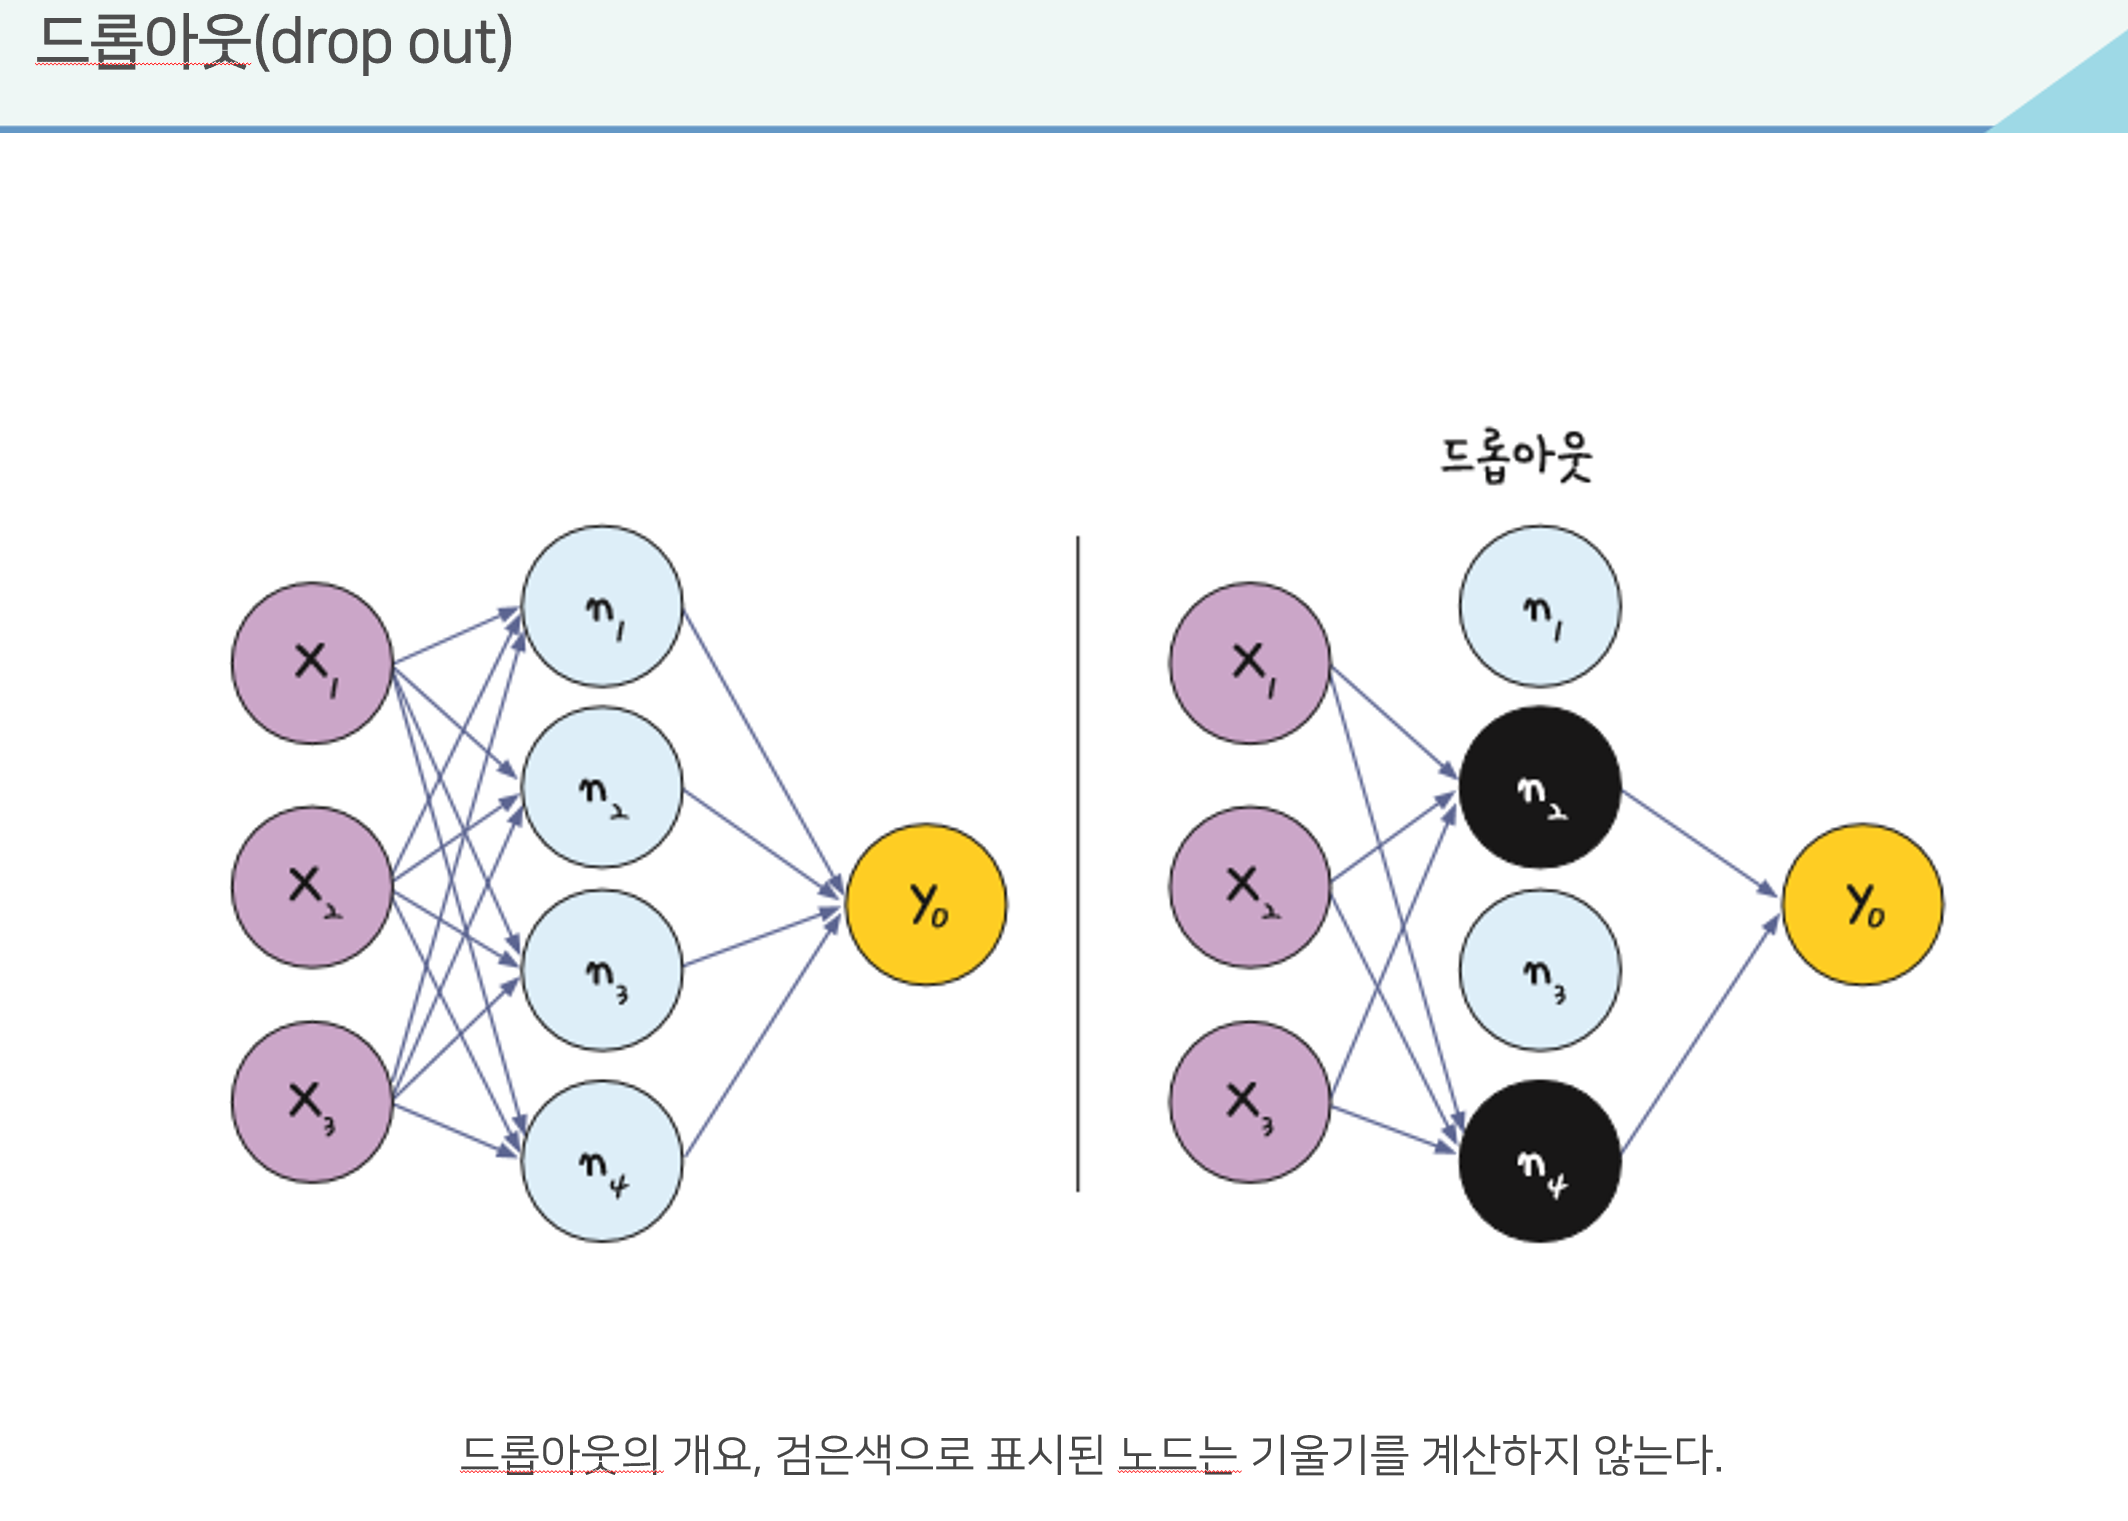

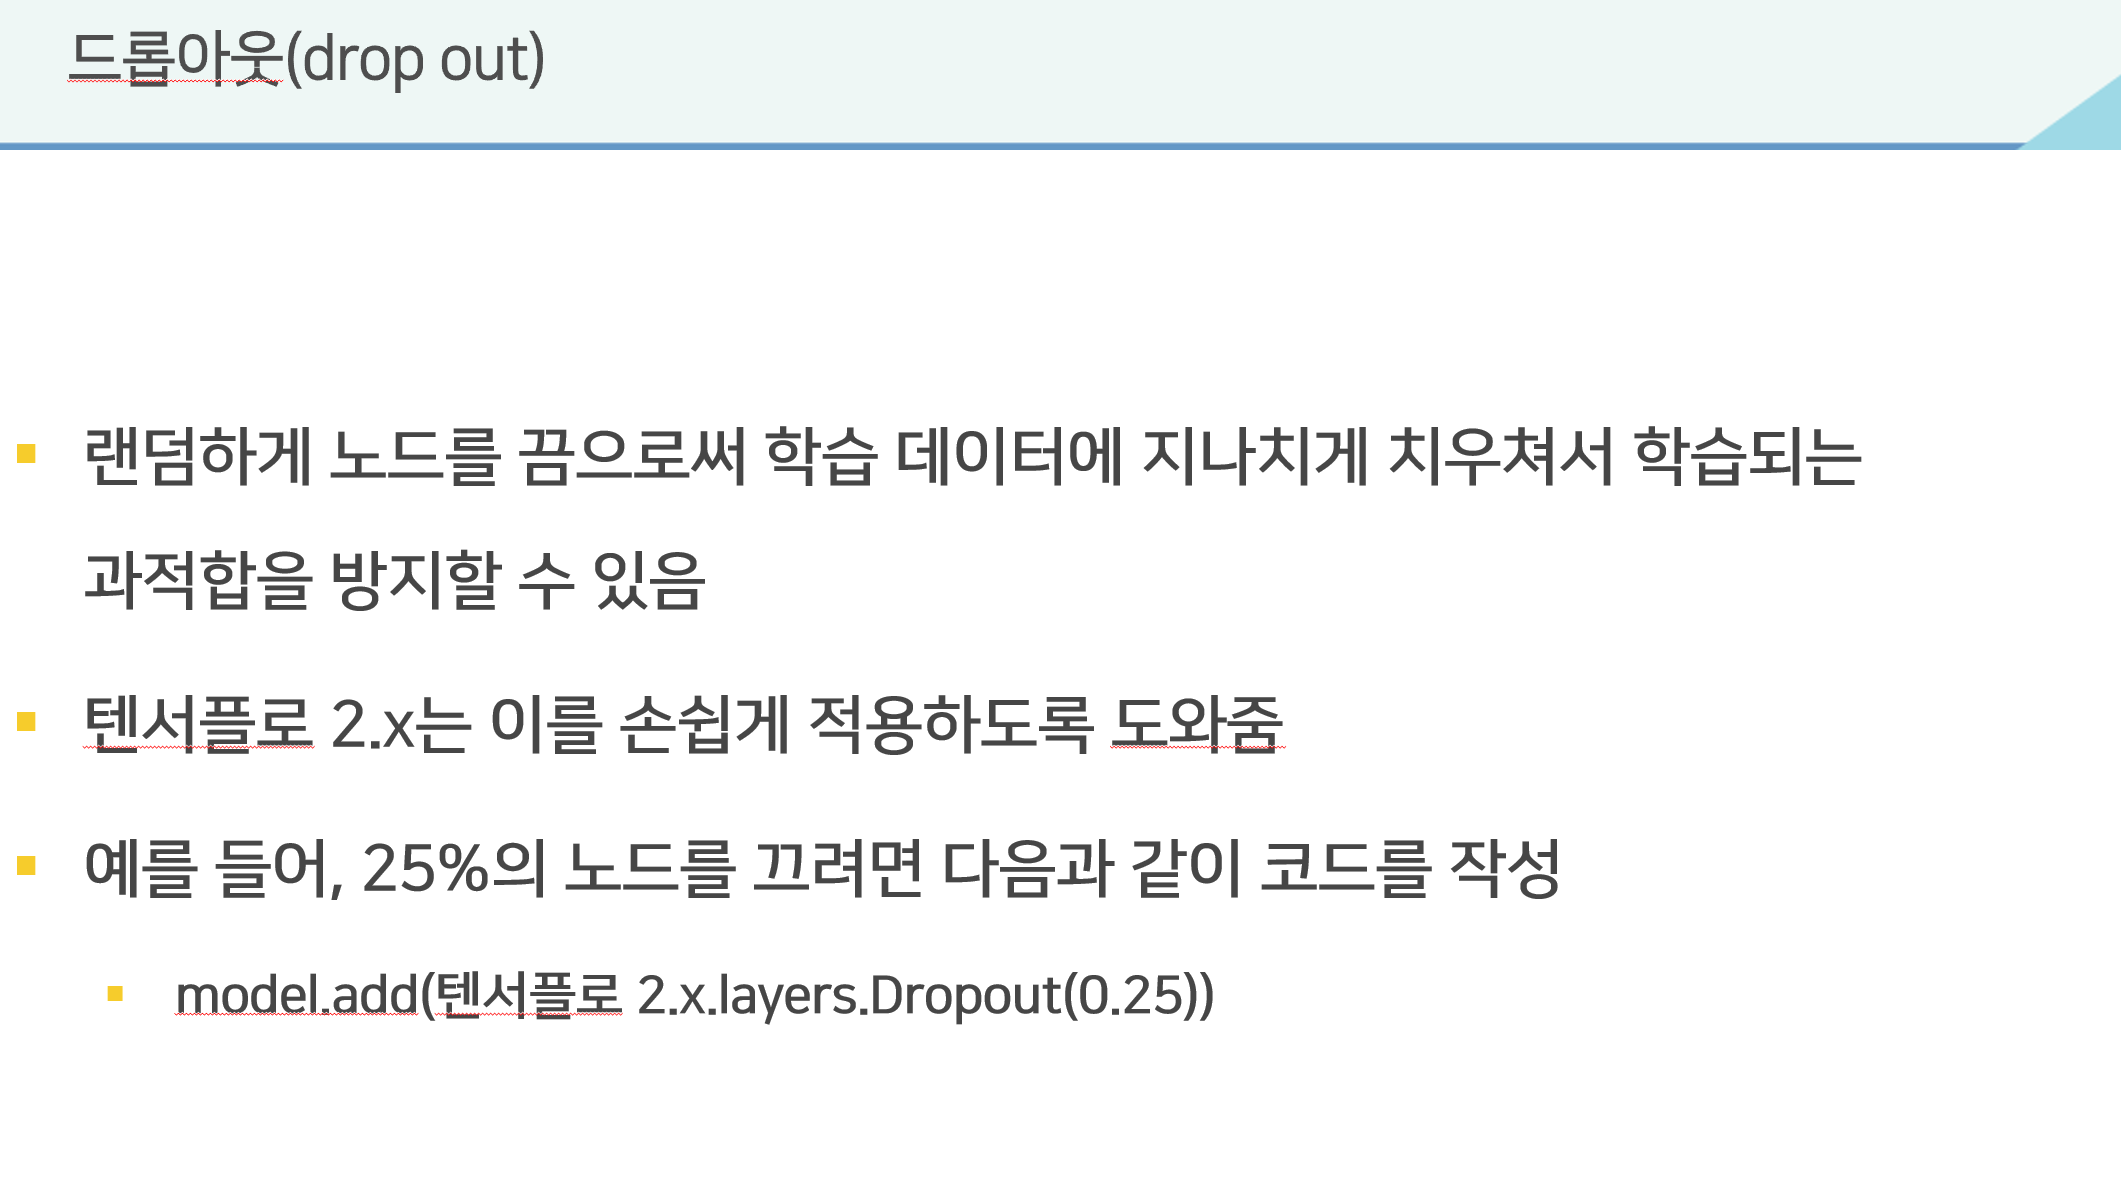

In [49]:
#전체 데이터 중 50%에 대해서만 기울기를 계산해서 수정
model.add(Dropout(0.5))

In [50]:
#선형 회귀를 하기 위해서 합성곱 연산을 수행한 결과를 1차원 배열로 변환
model.add(Flatten())

In [51]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터의 칸의 수는 256 이므로
#Dense(256)  
# activation="relu" :선형 회귀 후 relu 활성 함수 사용
#model.add(Dense(256, activation='relu')) :Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(256, activation='relu'))

In [52]:
#전체 데이터 중 20%에 대해서만 기울기를 계산해서 수정
model.add(Dropout(0.8))

In [53]:
#Dense : 선형 회귀를 수행할 객체
#Dense(출력데이터의 칸의수) : 출력 데이터 칸의 수는 3이므로
#Dense(3)

#Dense(3) : 선형 회귀를 할 객체를 생성  출력 칸수는 3
    
# activation="softmax" :선형 회귀 후 softmax 함수를 활성 함수를 이용해서 다중분루  
    
    
#model.add(Dense(3, activation="softmax")):Dense 모델을 예측 할 수 있도록 model에 추가
model.add(Dense(3, activation="softmax"))

In [54]:
#생성된 모델 정보 출력
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

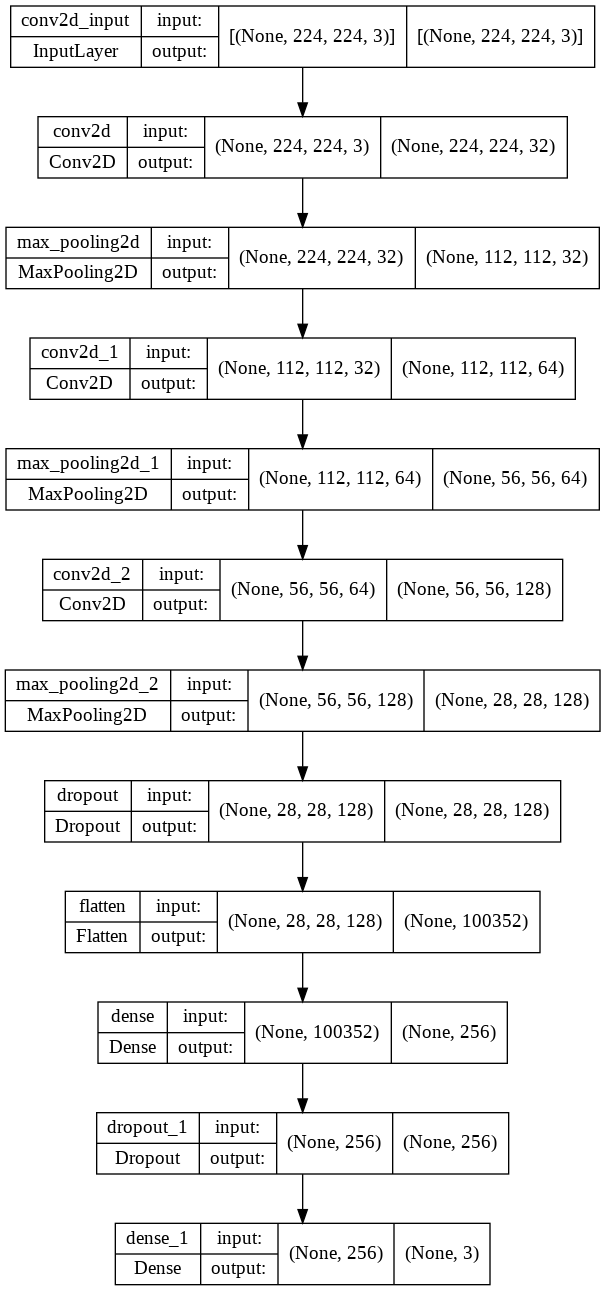

In [55]:
from tensorflow.keras.utils import plot_model
# model 시각화
plot_model(model, show_shapes=True)

In [56]:
from tensorflow.keras.optimizers import Adam

In [57]:
#GradientDecnet를 이용해서 w1,w2,w3,w4를 찾는 방법을 설정함
#loss='categorical_crossentropy' : -(y * tf.log(hypothesis1)) 합 이 최소가 되는 w1,w2,w3,w4 를 찾음
#optimizer=Adam(lr=1e-4) : learning rate를 0.0001 로 설정
model.compile(
                  loss="categorical_crossentropy", 
                   optimizer=Adam(lr=1e-4),
                   metrics=["acc"]
              )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 데이터 증강

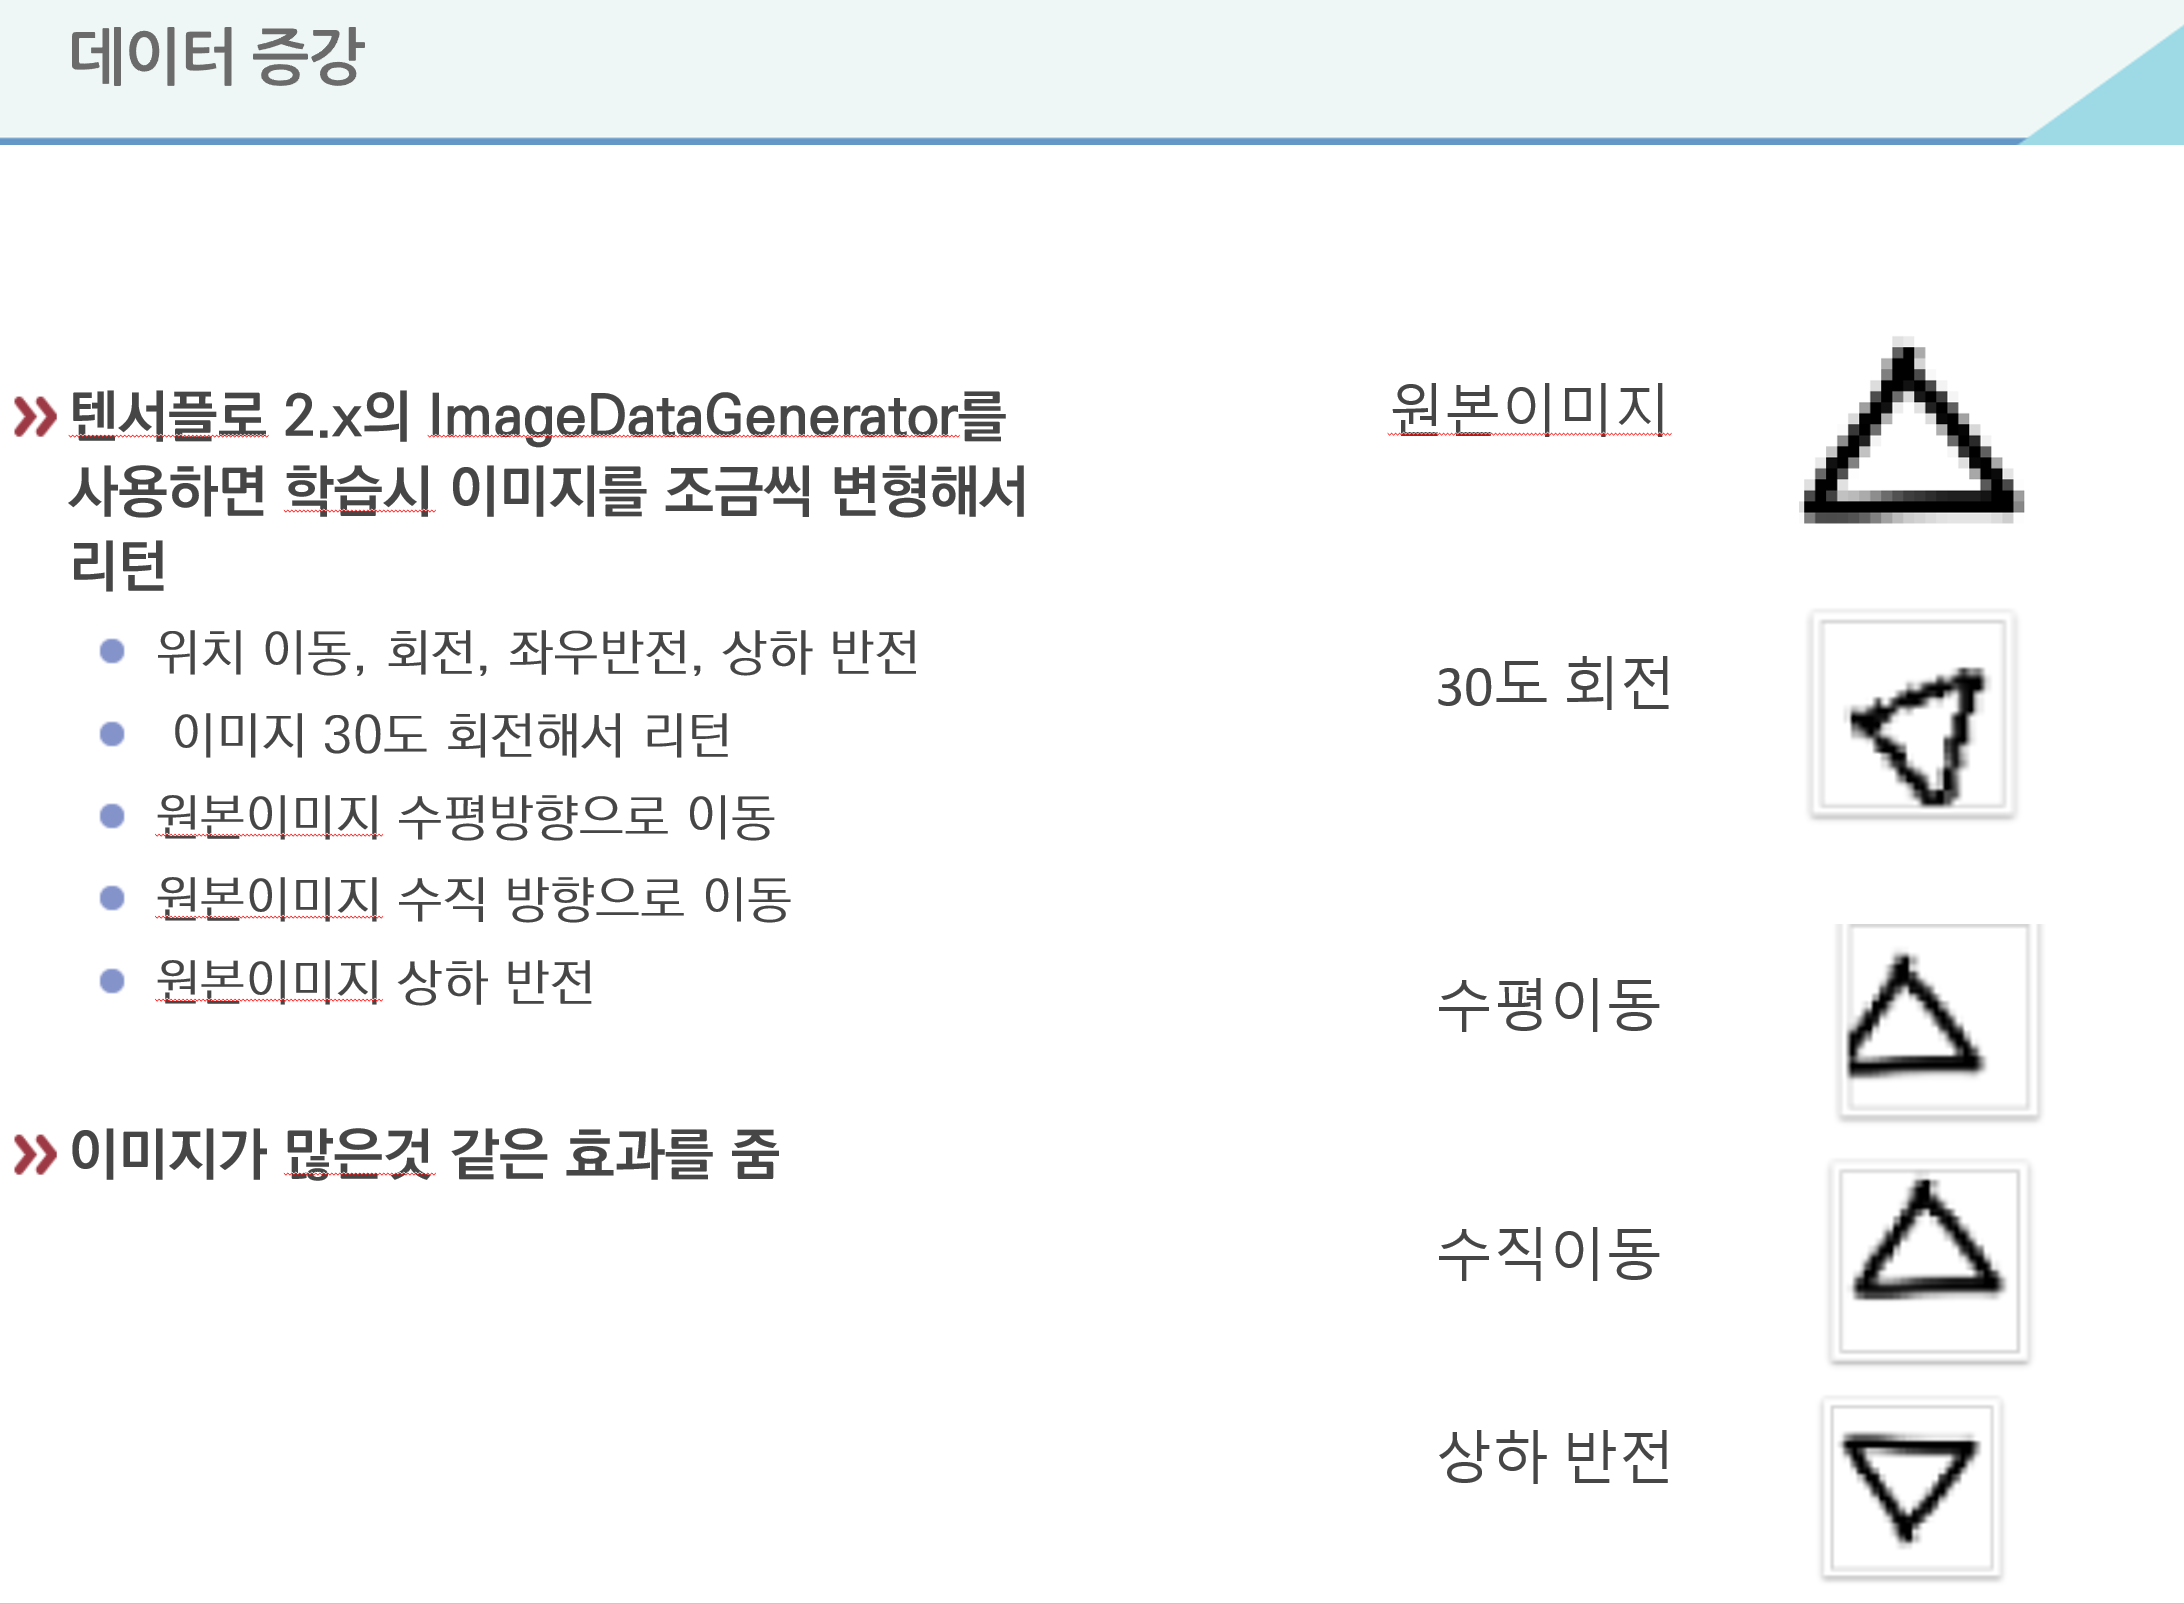

In [58]:
# 이미지를 증강하는 ImageGenerator 객체 생성
train_datagen = ImageDataGenerator(
	rotation_range=30, # 이미지 회전 각도
	zoom_range=0.15, # 이미지 확대 비율
	width_shift_range=0.2, # 이미지 가로 이동 비율
	height_shift_range=0.2, # 이미지 세로 이동 비율
	shear_range=0.15, # 이미지 기울기 비율
	horizontal_flip=True,# 이미지 좌우 반전
	rescale=1/255 # 이미지에 1/255 를 곱해줌
	)

In [59]:
#0번째 이미지 조회
X_train[0]

array([[[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       ...,

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]],

       [[16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.],
        ...,
        [16., 16., 16.],
        [16., 16., 16.],
        [16., 16., 16.]]

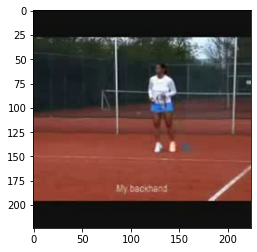

In [60]:
# 0번째  이미지
plt.imshow(X_train[0]/255)

In [61]:
X_train[0].shape

(224, 224, 3)

In [62]:
index=0
#증강시킨 20개의 이미지를 저장할 리스트
all_generate_img=[]

#train_datagen.flow(X_train[0]) : X_train[0] 를 회전, 수평이동, 수직이동, 좌우반전, 상하 반전등으로 증강 시켜서 리턴
#generate_img : 증강 시킨 데이터가 저장됨
for generate_img in train_datagen.flow(X_train[0].reshape(-1, 224, 224,3) ):
    #all_generate_img.append(generate_img): generate_img 증강시킨 이미지를 all_generate_img 에 추가 
    all_generate_img.append(generate_img)
    index += 1
    if index > 20:
        break  

In [63]:
all_generate_img

[array([[[[0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          ...,
          [0.117925  , 0.14537598, 0.117925  ],
          [0.12688334, 0.15433432, 0.12688334],
          [0.17503701, 0.20248799, 0.17503701]],
 
         [[0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          ...,
          [0.16895944, 0.19641043, 0.16895944],
          [0.20962538, 0.23707636, 0.2098393 ],
          [0.19036391, 0.21781489, 0.192504  ]],
 
         [[0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          [0.0627451 , 0.0627451 , 0.0627451 ],
          ...,
          [0.19279493, 0.22024591, 0.19469191],
          [0.17353347, 0.20098446, 0.1773566 ],
          [0.1378227 , 0.17075679, 0.15271048]],
 
         ...,
 
         [[0.5647059 , 0.2509804 , 0.19607845],
          [0.56470

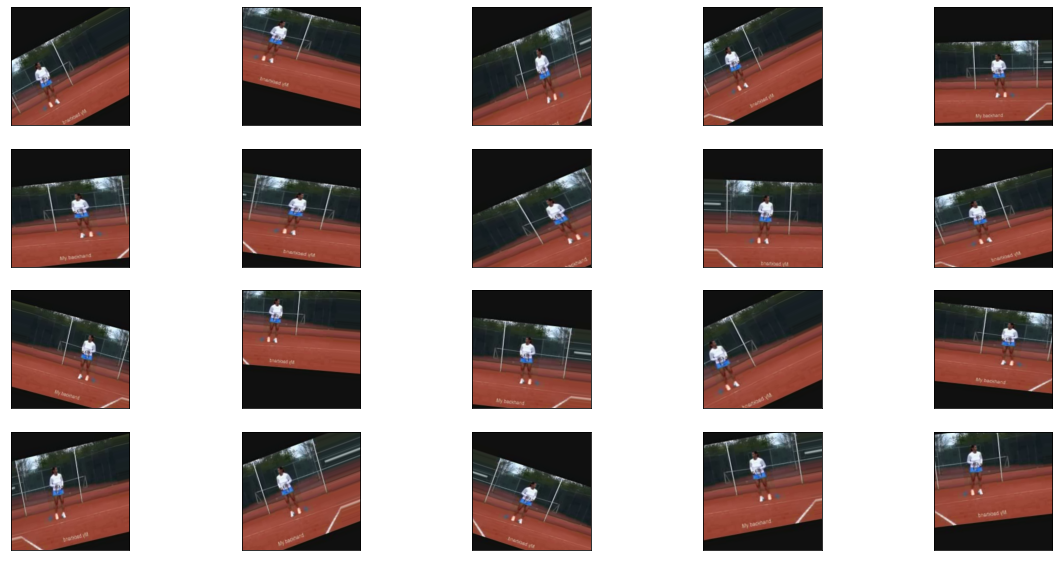

In [64]:
#이미지를 출력할 객체

fig = plt.figure(figsize=(20, 10))

for i in range(20):
    #4줄 5칸으로 나누고 i+1번째 이미지를 그림
    subplot = fig.add_subplot(4, 5, i + 1)
    
    #subplot.set_xticks([]) : 그래프의 x축을 설정 
    #데이터가 없으므로 x축에 아무 데이터도 출력 안됨
    subplot.set_xticks([])
    
    #subplot.set_yticks([]) : 그래프의 y축을 설정 
    #데이터가 없으므로 y축에 아무 데이터도 출력 안됨
    subplot.set_yticks([])   
    
    #증강된 이미지 출력 (X_train[0]을 회전 이동으로 데이터가 많은것 같은 효과를 줌)
    subplot.imshow(all_generate_img[i][0])
#그래프를 화면에 그림
plt.show()

# CNN 학습및 만든 CNN 모델 저장

In [65]:
# 이미지 학습
model.fit(
	# 32개의 이미지씩 증강해서 학습  
	train_datagen.flow(X_train, y_train, batch_size = 32),
    # 5번 반복해서 전체 이미지 학습 
	epochs = 5 )

Epoch 1/5
223/223 [==============================] - 88s 354ms/step - loss: 0.5287 - acc: 0.7726
Epoch 2/5
223/223 [==============================] - 71s 319ms/step - loss: 0.2053 - acc: 0.9157
Epoch 3/5
223/223 [==============================] - 71s 320ms/step - loss: 0.1441 - acc: 0.9459
Epoch 4/5
223/223 [==============================] - 71s 317ms/step - loss: 0.0966 - acc: 0.9649
Epoch 5/5
223/223 [==============================] - 71s 317ms/step - loss: 0.0877 - acc: 0.9674


In [67]:
# CNN 모델 저장
#model.save(data_path+"cnn_train.h5")